In [1]:
# Import the required libraries
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from features_helper import *

C:\Users\Claire Lefrancq\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_path = 'data/diplomacy_data.json'

# Load the json data
with open(data_path) as data_file:
    data_json = json.load(data_file)

## Loading the features

In [3]:
# Load all the seasons and remember their friendship id
seasons = pd.json_normalize(data_json, record_path=['seasons'], meta=['idx'])
# Select only the seasons that correspond to a friendly action (support)
seasons_with_support = seasons[(seasons['interaction.victim'] == 'support') | (seasons['interaction.betrayer'] == 'support')]
# Get the last friendly action for each friendship
last_friendly_action = seasons_with_support.groupby('idx', as_index=False).last()
last_friendly_action = last_friendly_action[['idx', 'season']]
last_friendly_action = last_friendly_action.rename(columns={'season': 'last_season'})
last_friendly_action

,idx,last_season
0,0,1909.0
1,1,1916.0
2,2,1915.5
3,3,1903.5
4,4,1911.5
...,...,...
495,495,1911.5
496,496,1912.5
497,497,1908.0
498,498,1906.0


In [4]:
features_betrayer = load_season_features(data_json, last_friendly_action, 'betrayer')
features_victim = load_season_features(data_json, last_friendly_action, 'victim')

In [27]:
features = pd.concat([features_betrayer, features_victim])
friendships = features.groupby(['idx', 'player_type']).mean()
friendships.head()

season  betrayal   support  n_requests    n_words  \
idx player_type                                                           
0   betrayer     1907.750000      True  1.000000    2.830952  75.411111   
    victim       1907.750000      True  0.166667    2.069444  72.972222   
1   betrayer     1913.583333     False  1.000000    0.750000  12.083333   
    victim       1912.500000     False  0.200000    0.800000  22.400000   
2   betrayer     1913.055556     False  0.444444    1.111111  60.888889   

                 politeness  n_sentences  sentiment.positive  \
idx player_type                                                
0   betrayer       0.792530     3.792063            1.046032   
    victim         0.685290     5.597222            1.083333   
1   betrayer       0.432853     1.416667            0.000000   
    victim         0.493841     2.400000            0.200000   
2   betrayer       0.558239     2.444444            0.333333   

                 sentiment.neutral  sentiment.negative  temporal  \
idx player_type                                                    
0   betrayer              1.192857            1.553175  0.662698   
    victim                1.458333            3.055556  0.430556   
1   betrayer              0.583333            0.833333  0.000000   
    victim                1.200000            1.000000  0.200000   
2   betrayer              0.666667            1.444444  0.055556   

                 subjectivity  expansion  contingency   premise  planning  \
idx player_type                                                             
0   betrayer        13.598413   1.153175     0.942063  0.854762  0.714286   
    victim          10.527778   0.750000     0.263889  1.680556  0.500000   
1   betrayer         1.083333   0.250000     0.166667  0.083333  0.166667   
    victim           2.400000   0.600000     0.400000  0.200000  0.400000   
2   betrayer         5.000000   0.000000     0.055556  0.333333  0.000000   

                 comparison     claim  last_season  n_messages  
idx player_type                                                 
0   betrayer       0.623810  0.418254       1909.0    4.166667  
    victim         0.430556  0.222222       1909.0    2.833333  
1   betrayer       0.166667  0.000000       1916.0    1.333333  
    victim         0.600000  0.000000       1916.0    1.000000  
2   betrayer       0.000000  0.111111       1915.5    1.222222

## 1. Observing the significance of support in friendships

In [76]:
support = friendships[['betrayal', 'support']]

# imbalance = victim - betrayer
support_imbalance = support['support'].diff()
support_imbalance = support_imbalance.reset_index(level='player_type').rename(columns={'support': 'imbalance'})
support_imbalance = support_imbalance[support_imbalance['player_type'] == 'victim']['imbalance'].to_frame()
support = support.reset_index()
support_imbalance = support_imbalance.merge(support[support['player_type'] == 'victim'][['idx', 'betrayal']], on='idx')
support_imbalance = support_imbalance.drop(columns='idx')

In [77]:
# average number of support action during the friendship
support = support.drop(columns='idx')
support.head()

,player_type,betrayal,support
0,betrayer,True,1.000000
1,victim,True,0.166667
2,betrayer,False,1.000000
3,victim,False,0.200000
4,betrayer,False,0.444444


In [78]:
support_imbalance.head()

,imbalance,betrayal
0,-0.833333,True
1,-0.800000,False
2,0.430556,False
3,-0.250000,False
4,0.500000,False


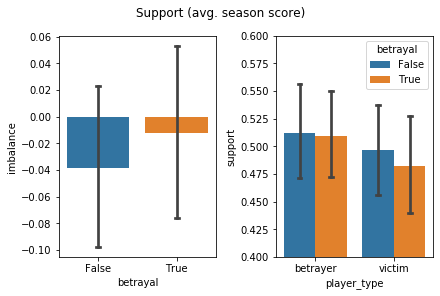

In [82]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
fig.suptitle('Support (avg. season score)')

ax[1] = sns.barplot(x="player_type", y="support", hue="betrayal", data=support, capsize=.05)
plt.ylim([0.4, 0.6])

_ = sns.barplot(ax=ax[0], x="betrayal", y="imbalance", data=support_imbalance, capsize=.05)

## Conclusion on support:
### // TODO

## 2. Variance in the features (? ou un autre titre jsp trop comment formuler)

\+ explication **//TODO**

In [93]:
variances = friendships = features.groupby(['idx', 'player_type', 'betrayal']).var().drop(columns=['season', 'last_season'])
variances.head()

support  n_requests      n_words  politeness  \
idx player_type betrayal                                                  
0   betrayer    True      0.000000    2.655907  2540.127407    0.020917   
    victim      True      0.166667    1.690046  1747.871296    0.013497   
1   betrayer    False     0.000000    0.575000    29.041667    0.013631   
    victim      False     0.200000    0.700000   289.800000    0.080186   
2   betrayer    False     0.277778    2.611111  1756.111111    0.037439   

                          n_sentences  sentiment.positive  sentiment.neutral  \
idx player_type betrayal                                                       
0   betrayer    True         2.919426            0.694618           0.461893   
    victim      True         6.490046            0.086111           1.543750   
1   betrayer    False        0.241667            0.000000           0.241667   
    victim      False        2.300000            0.200000           1.200000   
2   betrayer    False        4.965278            0.500000           1.000000   

                          sentiment.negative  temporal  subjectivity  \
idx player_type betrayal                                               
0   betrayer    True                0.209346  0.549301     73.932396   
    victim      True                2.374074  0.212269     24.449074   
1   betrayer    False               0.166667  0.000000      1.841667   
    victim      False               1.500000  0.200000      3.300000   
2   betrayer    False               1.465278  0.027778     30.812500   

                          expansion  contingency   premise  planning  \
idx player_type betrayal                                               
0   betrayer    True       0.740775     1.733791  0.142438  0.504082   
    victim      True       0.175000     0.051157  2.545602  0.211111   
1   betrayer    False      0.175000     0.166667  0.041667  0.166667   
    victim      False      0.800000     0.800000  0.200000  0.300000   
2   betrayer    False      0.000000     0.027778  0.187500  0.000000   

                          comparison     claim  n_messages  
idx player_type betrayal                                    
0   betrayer    True        0.609116  0.607714    4.566667  
    victim      True        0.212269  0.062963    0.566667  
1   betrayer    False       0.166667  0.000000    0.266667  
    victim      False       0.800000  0.000000    0.000000  
2   betrayer    False       0.000000  0.111111    0.194444